In [2]:
import os
import cv2
import numpy
import glob
import math
import collections
from shutil import copyfile
from time import time
import numpy as np
import pandas as pd
from scipy import stats

from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter

In [3]:
BASE_DIR = '/Users/nalingupta/Documents/Documents /NEU/DS5500 Capstone Project/Project/Test Videos'

In [3]:
def calc_hist(img):
    '''calculates b,g,r histograms of image'''
    bHist = cv2.calcHist([img],[0],None,[256],[0,256])
    gHist = cv2.calcHist([img],[1],None,[256],[0,256])
    rHist = cv2.calcHist([img],[2],None,[256],[0,256])
    return bHist,gHist,rHist

In [4]:
def fit_predict_HMM(X,y,lengths=None,n_components=3):
    '''fitting hmm to 2d array X and returning predictions on y'''
    model = hmm.GaussianHMM(n_components=n_components)
    model.fit(X,lengths=lengths)
    preds = model.predict(y)
    return preds

In [6]:
%%time
frames = []

bArray = []
gArray = []
rArray = []

frames = []
frame_ids = sorted(glob.glob(os.path.join(BASE_DIR, 'shots', '*.png')))

for frame_id in frame_ids:
    frame = cv2.imread(frame_id)
    bHist,gHist,rHist = calc_hist(frame)
    #adding mode of each histogram to list
    bArray.append(np.argmax(bHist))
    gArray.append(np.argmax(gHist))
    rArray.append(np.argmax(rHist))
    # # adding mean of each histogram to list
    # bArray.append(findMean(bHist))
    # gArray.append(findMean(gHist))
    # rArray.append(findMean(rHist))
    # # adding median of each histogram to list
    # bArray.append(findMedian(bHist))
    # gArray.append(findMedian(gHist))
    # rArray.append(findMedian(rHist))

histArray = np.column_stack([bArray,gArray,rArray])
video1_hmm = fit_predict_HMM(histArray,histArray,n_components=3)

CPU times: user 12.9 s, sys: 744 ms, total: 13.6 s
Wall time: 14.6 s


In [26]:
frames = []

bArray = []
gArray = []
rArray = []

frames = []
frame_ids = sorted(glob.glob(os.path.join(BASE_DIR, 'other_transition', '*.png')))

for frame_id in frame_ids:
    frame = cv2.imread(frame_id)
    bHist,gHist,rHist = calc_hist(frame)
    #adding mode of each histogram to list
    bArray.append(np.argmax(bHist))
    gArray.append(np.argmax(gHist))
    rArray.append(np.argmax(rHist))
    # # adding mean of each histogram to list
    # bArray.append(findMean(bHist))
    # gArray.append(findMean(gHist))
    # rArray.append(findMean(rHist))
    # # adding median of each histogram to list
    # bArray.append(findMedian(bHist))
    # gArray.append(findMedian(gHist))
    # rArray.append(findMedian(rHist))

histArray = np.column_stack([bArray,gArray,rArray])
video2_hmm = fit_predict_HMM(histArray,histArray,n_components=3)

In [27]:
true, pred = get_metrics(list(video1_hmm) + list(video2_hmm), 
            list(video1_annotation)+list(video2_annotation))

              precision    recall  f1-score   support

           0       0.78      0.93      0.85        96
           1       0.92      0.76      0.83       103

    accuracy                           0.84       199
   macro avg       0.85      0.84      0.84       199
weighted avg       0.85      0.84      0.84       199



In [14]:
class ShotSegmentation:
    def __init__(self, frames_dir):
        self.frames_dir = frames_dir
        self.frame_ids, self.frames = self.get_frames()
        self.encoded_frames = None
        
        self.tsne_X = None
        self.db = None
    
    def get_frames(self):
        frames = []
        frame_ids = sorted(glob.glob(os.path.join(self.frames_dir, '*.png')))
        
        for frame_id in frame_ids:
            frame = load_img(frame_id, target_size=(224, 224))
            frame = img_to_array(frame)
            frame = preprocess_input(frame)
            frames.append(frame)
        
        return frame_ids, np.array(frames)
    
    def get_clusters(self, perplexity=35, eps=7, min_samples=10):
        # Encoding frames using VGG16
        vgg16 = VGG16()
        vgg16 = Model(inputs=vgg16.inputs, outputs=vgg16.layers[-2].output)
        
        self.encoded_frames = vgg16.predict(self.frames)
        
        print('> Finished encoding frames using VGG16')
        
        # TSNE Reduction
        tsne = TSNE(n_components=2, init='pca',
                         random_state=0, perplexity=perplexity)
        self.tsne_X = tsne.fit_transform(self.encoded_frames)
        
        print('> Performed dimensionality reduction using TSNE')
        
        # DBSCAN clustering
        self.db = DBSCAN(eps=7, min_samples=10).fit(self.tsne_X)
        
        print('> Created clusters using DBSCAN')
        
        return self.db.labels_
    
    def dbscan_plot(self):
        core_samples_mask = np.zeros_like(self.db.labels_, dtype=bool)
        core_samples_mask[self.db.core_sample_indices_] = True
        labels = self.db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)
        
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = self.tsne_X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = self.tsne_X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.show()

In [15]:
def get_metrics(labels, annotation):
    true = []
    pred = []
    
    for a, l in zip(annotation, labels):
        if not pd.isna(a):
            if l == 0:
                true.append(0)
            else:
                true.append(1)
            
            if a == 'gameplay':
                pred.append(0)
            else:
                pred.append(1)
    
    print(classification_report(true, pred))
    
    return true, pred

In [16]:
%%time
video1_segmentation = ShotSegmentation(os.path.join(BASE_DIR, 'test'))
video1_labels = video1_segmentation.get_clusters()

> Finished encoding frames using VGG16
> Performed dimensionality reduction using TSNE
> Created clusters using DBSCAN
CPU times: user 48.8 s, sys: 6.52 s, total: 55.3 s
Wall time: 9.34 s


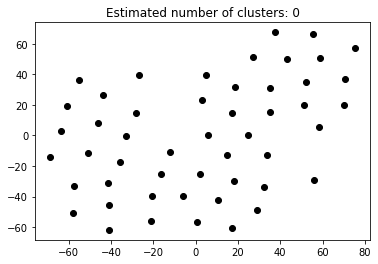

In [17]:
video1_segmentation.dbscan_plot()

In [16]:
%%time
video2_segmentation = ShotSegmentation(os.path.join(BASE_DIR, 'other_transition'))
video2_labels = video2_segmentation.get_clusters()

> Finished encoding frames using VGG16
> Performed dimensionality reduction using TSNE
> Created clusters using DBSCAN
CPU times: user 17min 21s, sys: 1min 13s, total: 18min 35s
Wall time: 2min 17s


In [19]:
video1_annotation_df = pd.read_csv(os.path.join(BASE_DIR, 'shots_annotation.csv'), header=0)
video1_annotation = list(video1_annotation_df['Label'])

In [20]:
video2_annotation_df = pd.read_csv(os.path.join(BASE_DIR, 'other_transition_annotation.csv'), header=0)
video2_annotation = list(video2_annotation_df['Label'])

In [33]:
true, pred = get_metrics(list(video1_labels) + list(video2_labels), 
            list(video1_annotation)+list(video2_annotation))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       116
           1       0.98      1.00      0.99        83

    accuracy                           0.99       199
   macro avg       0.99      0.99      0.99       199
weighted avg       0.99      0.99      0.99       199



In [37]:
collections.Counter(true)

Counter({0: 116, 1: 83})

In [ ]:
# results_folder = os.path.join(base_dir, 'segmentation_results', 'longer_segmentation')
# for label, img in zip(db.labels_, frames):
#     result_dir = os.path.join(results_folder, str(label))
#     result_dest = os.path.join(results_folder, str(label), os.path.split(img)[1])
#     if not os.path.exists(result_dir):
#         os.makedirs(result_dir)
#     copyfile(img, result_dest)